# **GeoWizard: Classifying Satellite Images using Convolutional Neural Networks**
## **Improving Predictions using Custom Augmentations?**

## ***Disclaimer!***
This notebook is meant to be used by anyone interested in replicating our model or playing around with the satellite predictions. In order to access all features, please go to this [Google Drive Folder](https://drive.google.com/drive/folders/16Ypuxfolx_UYtRBBE6gU1wixhG6tR_lm) and store it on your own Google Drive. By clicking on the folder name "DLiP_Group6" and selecting "Add a shortcut to Drive", all necessary files are automatically shared with your main Drive environment without having to download all the data or files individually! After that, simply run all the code as you like.

### **Outline of Project**

1. **Introduction and General Aim**
2. **Methods: The Data, Model Configuration, and Fitting**
3. **Results and Analyses**
4. **Discussion and Concluding Remarks**

### ***General Idea and Larger Context***
The aim of this project is to train a neural network on recognizing different landscapes and objects associated with them by classifying satellite images. Nowadays, various localization tasks such as urban planning or land utilization for underdeveloped regions are highly relevant and depend on the evaluation of large areas. Advanced land and object detection techniques using satellite images offer a quick and convenient tool for experts in those fields and enable them to execute their responsibilities more efficiently (Albert et al., 2017). To assist in this effort, the present project utilizes a convolutional neural network (CNN) architecture (Kadhim & Abed, 2019). As CNNs have been proven to be particularly useful for image processing and classification, the general framework of this project will revolve around building a custom classifier, however, involving pre-trained weight matrices. Considering the data source being satellite images, we were interested in applying different augmentation techniques to explore what image distortions make sense. In this context, we want to investigate a custom data augmentation method manipulating the RGB layers of images individually. Here, we are interested in comparing this model to a baseline model only utilizing recommended augmentations. Additionally, to create a generalizable model, we performed robustness analyses and tested the model on a function accessing satellite images and classifying them simultaneously.

### ***Bayes Upper Bound Error***

The present model extracts features from satellite images, which tend to be noisy and even for humans often not easily identifiable. Prior research has shown that certain pre-trained CNN structures can reach up to 90-98% on comparable data sets involving satellite imagery, like UCmerced (Kadhim & Abed, 2019). To provide a human baseline, the group members tried to classify the images from the given data set and achieved an average accuracy of about 60-70%.

### ***Imports***
Before we commence the network training, standard and third party library imports are required. These include the usual data science packages (e.g., numpy, matplotlib) as well as more specialized libraries enabling the construction of neural networks (e.g., tensorflow) and image processing capabilities (e.g., PIL). Additionally, we have to define the directory from where we retrieve our resources. 

In [ ]:
# Standard Library Imports
import os
import requests
import random
import pathlib

# Third Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.python.framework.ops as cops
import tensorflow.python.ops as tops
from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from scipy import stats
from PIL import Image
from io import BytesIO
from pathlib import Path
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

# Temporary pip install of Third Party Import (for random latitude and longitude coordinates)
%pip install -q faker
from faker import Faker

# Define directory to access image folders, labels, and pre-trained models
drive.mount('/content/drive', force_remount = True)
our_data_dir = '/content/drive/MyDrive/DLiP_Group6/AID'                        

### ***Helper Functions & Model Loading***

For this project we wrote various custom functions for different purposes. In order to reduce the amount of code chunks within the notebook and improve readability, we collected all these functions below. Additionally, the first code chunk is loading the two models trained during this project:
* Loading of Models trained with and without custom RGB layer (to avoid retraining)
* Custom keras layer manipulating the individual RGB layers of images
* Custom ROC curves to account for multiclass comparisons
* Custom function for accessing Google Maps satellite images and predicting these using the pre-trained model

**Note:** To be able to run all parts of this notebook please execute the below functions once at the beginning. This may take some seconds. To gain access to the models, please follow the Disclaimer section at the beginning of this notebook (they must be located in your Google drive)!

#### ***Loading both pre-trained models***

In [ ]:
model_no_rgb = keras.models.load_model('/content/drive/MyDrive/DLiP_Group6/ResNet_NoRGB')
model_rgb    = keras.models.load_model('/content/drive/MyDrive/DLiP_Group6/ResNet_RGB')

# Define class names as multiple functions will use it
class_names = ['Airport',                                                  
               'BareLand', 'BaseballField', 'Beach', 'Bridge', 
               'Center', 'Church', 'Commercial', 
               'DenseResidential', 'Desert', 
               'Farmland', 'Forest', 
               'Industrial', 
               'Meadow', 'MediumResidential', 'Mountain', 
               'Park', 'Parking', 'Playground', 'Pond', 'Port', 
               'RailwayStation', 'Resort', 'River', 
               'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 
               'Viaduct']

#### ***Custom keras layer for manipulating the individual RGB layers of images***

In [ ]:
# The following functions were inspired by: https://github.com/tensorflow/tensorflow/blob/v2.11.0/tensorflow/python/ops/image_ops_impl.py#L2542-L2575
def rgb_to_rgb(images, RGB, prob , name=None):
    '''
    Takes in an image tensor and returns a new image tensor with the R-G-B channels 
    multiplied by the corresponding values in RGB. For example, if RGB = [.2,.3,.4],
    multiply the R channel matrix by .2, G channel matrix by .3, and B channel matrix 
    by .4. Modified from the rgb_to_grayscale function.

    Args:
        images: Image tensor as input.
        RGB: List of three floats representing values each color channel is 
          multiplied by. Defaults to random values between 0-1.
        prob: Float encoding the probability of transformation occuring.
        
    Returns:
        Image tensor with transformed channels.
    '''
    if (prob):                                                                  # if number bigger than threshold, original image is returned
        return(images)
    
    else: 
        with cops.name_scope(name, 'rgb_to_rgb', [images]) as name:
            images = tf.convert_to_tensor(images, name = 'images')              # make image a tensor for upcoming operations
            orig_dtype = images.dtype                                           # save datatype of original input (important if not tf.float32)
            flt_image = tf.image.convert_image_dtype(images, tf.float32)        # converts the image into a tf.float32

            rgb_weights = RGB
            results = []
            for x, i in enumerate(rgb_weights):
                results.append(flt_image[:, :, x] * i)                          # multiply each layer of tensor with value corresponding to the layer

            return tf.image.convert_image_dtype(results, orig_dtype, name = name) 


class layers_RGBChange(keras.layers.Layer):
    '''
    Class callable in the kearas.models.Sequential. Transforms random images by 
    utilizing the rgb_to_rgb function and returns those RGB changed images.

    Attributes:
        rgb: List of three floats representing values each color channel is multiplied by.
        prob: Float encoding the probability of transformation occuring. Defaults to 0.5.

    Methods:
        get_random_transformation: Transforms the RGB to the desired shape.
        augment_image: Image gets augmented using passed objects.
        batch_augment: Conversion to vectorized_map for better performance.
        augment_label: Change label to correspond to the transformation.
        compute_output_shape: Shows how output of the picture/batch looks like.
        get_config: Add new information to already passed on dictionary to be 
          used deeper within network.
    '''
    def __init__(self, RGB = [], prob = 0.5, **kwargs):  
        
        super(layers_RGBChange, self).__init__(**kwargs)                        # allow other layers to call propreties passed from previous layers
        self.rgb = RGB                                   
        self.prob = prob

    def get_random_transformation(self, image = None, label = None, bounding_box = None):  
        RGB = [self.RGB[i] if i < len(self.RGB) else round(random.random(),2) for i in range(3)]
        return {'RGB_r':    RGB}                                                # add the value of RGB_r: how much values gonna be scaled for

    def augment_image(self, image, transformation): 
        original_shape = image.shape               
        comp_RGB = transformation['RGB_r']          
        comp_prob = self.prob > random.random()
        output = rgb_to_rgb(image, RGB = comp_RGB, prob = comp_prob)
        output = tf.clip_by_value(output, 0, 255)
        output.set_shape(original_shape)
        return output
    
    def batch_augment(self, inputs):
        return tf.vectorized_map(self._augment, inputs)

    def augment_label(self, label, transformation): 
        return label

    def compute_output_shape(self, input_shape): 
        return input_shape

    def get_config(self):
        config = {
            'RGB_out': self.rgb,                                                # define a dictionary with RGB_out scalar vector
            'prob_rgb': self.prob                                               # make system remember probabilty of being switched
        }
        base_config = super().get_config()                                      # call the existing dicitonary
        return dict(list(base_config.items()) + list(config.items()))           # put information in config base

#### ***Custom ROC curves to account for multiclass comparisons***

In [ ]:
# The following functions were inspired by: https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) 
    based on real and predicted observations.
    
    Args:
        y_real: The list or series with the real classes.
        y_pred: The list or series with the predicted classes.
        
    Returns:
        tpr: The True Positive Rate of the classifier.
        fpr: The False Positive Rate of the classifier.
    '''
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN)                                                         # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP)                                                        # 1-specificity - false positive rate
    
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each 
    point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by 
          using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted 
          with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

#### ***Custom function for accessing Google Maps satellite images and predicting these***

In [ ]:
# The following function is completely custom/hand-made
def predict_satellite_image(lat = 41.714728, lon = -73.998672):                 # Example latitude and longitude coordinates as default
    '''
    Displays a satellite picture retrieved from Google Maps and performs a prediction on it.
    
    Args:
        lat: Float representing the latitude coordinate of the chosen location.
        lon: Float representing the longitude coordinate of the chosen location.
        
    Returns:
        pred: String representing the class predicted by the model.
        display: Displays the given satellite image. 
        .
    '''
    api_key = 'Maps_Static_API_token'                                           # To access Google Maps Static API please insert your API key here (setting up an account is free!)
    url     = 'https://maps.googleapis.com/maps/api/staticmap?'                 # Standard web address to access Maps API
    center  = str(lat) + "," + str(lon)                                         # Positional Information: Latitude & Longitude coordinates
    
    response  = requests.get(url + 'center=' + center + '&zoom=18&size=300x325&maptype=satellite&key=' + api_key) # Request URL content

    geo_image = Image.open(BytesIO(response.content)).convert('RGB').crop((0, 0, 300, 300)) # Convert image to RGB and crop it to required size
    pix       = np.expand_dims(np.array(geo_image), axis = 0)                   # Transform requested image into tensorflow format (numpy)
    pred      = class_names[model_no_rgb.predict(pix, verbose = 0).argmax()]    # Perform prediction using model and class names

    display(geo_image)
    return(pred)

## **Methods**
### ***AID: A Benchmark Dataset for Performance Evaluation of Aerial Scene Classification***

The data used for training and validating our model concerns aerial (satellite) images (AID = [Aerial Image Dataset](https://paperswithcode.com/dataset/aid)). These samples were collected from Google Earth imagery. Precisely, the images are multi-source, meaning they are from numerous remote imaging sensors. Compared to similar data sets like UC merced, which is single source, the present data provides more of a challenge as it has a larger variety of classes which also come from varying measurement sources. Additionally, images were extracted under different conditions (e.g., across seasons), increasing the intra-class diversity (Xia et al., 2017). This emphasizes the need for appropriate augmentation methods and allows to build a model generalizable to other tasks in the realm of satellite imagery.

The data set consists of 10.000 images with 30 unique classes (e.g., School, Stadium, Airport, Bridge), thus, around 300-400 images per class. The images were obtained from many different regions and countries (e.g., China, USA, Germany, Japan) and experts in the field of remote sensing image interpretation labelled them.

To conclude: The present data concerns a multitude of classes, displaying a variety of landscapes, thus, providing a multiclass approach.

### ***Read-in of Data Set***
The tensorflow/keras library provides a convenient way of reading in our data. By using the following in-built function...
```
tf.keras.utils.image_dataset_from_directory
```
...we generate a data set from the image files provided in a directory. Here, it considers the directory structure and assigns class names to pictures based on their folder affiliation. Following, we will split the data into a train (70%), validation (10%), and test (20%) set. Note, we resized the images from 600x600 to 300x300 due to computational constraints when fitting the model. Predictions will consider this changeover.


In [ ]:
# Reading-in the train data set
train_set_ = tf.keras.utils.image_dataset_from_directory(                       # Training set
    our_data_dir,                                                               # Define directory where data is located
    validation_split = 0.3,                                                     # Fraction of data to reserve for validation
    label_mode = 'int',                                                         # "Int" = encodes labels as integers instead of e.g., one-hot encoding
    subset = 'training',                                                        # Which subset of the data should be returned: training data
    seed = 123,                                                                 # Specify seed for reproducibility
    image_size = (300, 300),                                                    # 600x600 images are resized to 300x300 due to standard and GPU memory allocation
    color_mode = 'rgb',                                                         # Images will be converted to "rgb" = 3 channels
    batch_size = 32,                                                            # Defines size of the mini-batches (stochastic gradient descent)
    shuffle = True                                                              # Specify data being shuffled prior to model fit
)
                                            
# Reading-in the validation and test data
val_test_set_ = tf.keras.utils.image_dataset_from_directory(                    # Validation + test set
    our_data_dir,                                                               
    validation_split = 0.3,                                                     
    label_mode = 'int',                                                         
    subset = 'validation',                                                      # Which subset of the data should be returned: validation data
    seed = 123,                                                                 
    image_size = (300, 300),                                                    
    color_mode = 'rgb',                                                         
    batch_size = 32,                                                            
    shuffle = True                                                              
)

# Separating the val_test dataset into validation and traning sets
val_batches = tf.data.experimental.cardinality(val_test_set_)
val_set_ = val_test_set_.skip((2*val_batches) // 3)                             # Take 10% of the data for validation
test_set_ = val_test_set_.take((2*val_batches) // 3)                            # And 20% for testing

# Print out class names to get an overview of categories in question
print(train_set_.class_names)

Found 10000 files belonging to 30 classes.
Using 7000 files for training.
Found 10000 files belonging to 30 classes.
Using 3000 files for validation.
['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']


Reading in the data worked as can be seen by the previous output, indicating that all 10.000 images have been loaded in and split in the defined dimensions of 7000:1000:2000 for training, validation, and testing purposes, respectively. We can also investigate the different classes that compose the data set, such as Airport, Forest, or Church.

Let's now *visually* investigate the original images and see how they look like:  

Parking


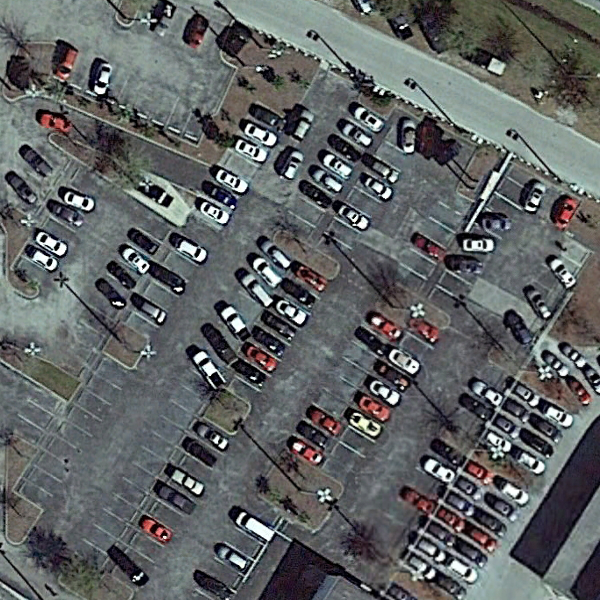

In [ ]:
# Display a random example picture
print(example_cat := random.choice(train_set_.class_names))  
example_pic_path = list(pathlib.Path(our_data_dir).glob(example_cat + '/*'))
(example_pic := Image.open(str(example_pic_path[random.randint(0, 100)])))

### ***Efficient Data Pipeline***

One more step is required before we start the model creation and fitting. Using 
`tf.data` we can use two crucial transformations in terms of computational efficiency. Using `tf.data.Dataset.cache` we can "cache" a data set in memory, preventing that certain operations are performed during each epoch. Additionally, `tf.data.Dataset.prefetch` is used to optimize the way data is processed during model training. Essentially, we want to make full use of the available GPU, therefore, during training (e.g., backpropagation) we tell the CPU to already process the next batch, being immediately available to the GPU as soon as it finished. We autotune this value. The above-mentioned methods will be applied to all data sets.

In [ ]:
# Efficient Data Pipeline for Train, Validation, and Test Data
AUTOTUNE = tf.data.AUTOTUNE                                                     # Value for "prefetch" is being autotuned
train_set = (
    train_set_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    )

val_set = (
    val_set_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    )

test_set = (
    test_set_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    )

### ***The Model Architecture***

The model architecture follows the usual CNN structure closely:
* **Convolution-Pooling Layers** (substituted by ResNet50)
* **Flattening Layer**
* **Fully-Connected Network** 
* **Output Layer** with *softmax* activation function for multiclass predictions

Due to exhaustive and exponential runtimes when training our own model, we decided to utilize the weights of a pre-trained network. In the case of image classification, two easy-to-access models stand out, namely VGG16 and ResNet50. Both were extensively pretrained on imageNet datasets and provide refined layers and weight structures. They both consist of varying compositions of Convolution and Pooling layers, using the ReLU activation function for feature enhancement. However, research showed that ResNet50 significantly outperforms VGG16 concerning the classification of satellite images. Specifically on data sets closely related to ours (e.g., UC merced) the differences were more pronounced (Albert et al., 2017; Kadhim & Abed, 2019). Hence, the present project will utilize ResNet50 as the base for the custom classifier, freezing its weights in the process and only including the respective base. By approaching the given problem with **transfer learning** we want to extensively train the head of our model, thus, creating a classification head specialized for the task at hand: Classifying satellite images.

ResNet is unique among very deep convolutional neural networks due to being able to solve the problem of the vanishing gradient efficiently. Its original architecture (ResNet34) is based on the VGG framework. One key difference to other CNNs is the usage of so-called *shortcut connections*, effectively skipping blocks of convolutional layers, enabling it to learn residual mappings between layer input and output. Essentially, gradients run through these connections from later layers to earlier filters (Albert et al., 2017; He at al., 2016). The below picture from He et al. 2016 illustrates the working of such a shortcut:

![](https://drive.google.com/uc?id=1NDOlT0rzcZqzzxslffhefXttTiUxCt7S)

We further adjusted the final model to the needs of the data, considering its nature. To this extent, we introduced various preprocessing steps to artificially inflate the training samples. The following techniques were used:
* **Flipping:** Images are flipped along the vertical and horizontal dimensions.
* **Rotation:** Images are rotated by a pre-specified angle.

Especially on geospatial data (e.g., satellite images) these distortions work well as the bird-eye-view from outer space entails rotating representations of landscapes (Albert et al., 2017). We also included a Dropout layer in order for the model to primarily learn general patterns and recognize redundancies caused by specific neurons. Both, the data augmentation and dropout methods, provide new ways of accounting for overfitting.

#### ***Custom Augmentation Layer***
A key goal of this project includes the comparison of two models. One using the discussed architecture and augmentation methods (baseline model = *model_no_rgb*) and a second model using an additional custom augmentation on top of that (experimental model = *model_rgb*). Inspired by Krizhevsky and colleagues (2017), we wrote a custom layer (located within the helper functions section at the beginning) that manipulates the values of the RGB layers individually (Tensorflow/Keras unfortunately does not provide such a layer by default). The manipulation of RGB colors makes sense as satellite images appear in different qualities, including low vs. high resolutions and more vs. less saturated images. Those differences could be caused by satellites utilizing varying types of cameras, depending on their deployment most likely also from different periods in time. By accounting for these differences, we hope to improve the model's predictions and make it more generalizable (Krizhevsky et al., 2017). Thus, the following data augmentaiton is added to the experimental model:

* **RGB Transformation:** Images' colour channels are individually multiplied by a uniformly drawn scalar (three numbers between 0-1) 

The below code chunk demonstrates how such a transformed image might look like. For this example, the R-G-B channels are multiplied by `[0.1, 0.6, 0.7]`. The resulting image shows a strong blue tint. For the experimental model, images are randomly converted in this way.

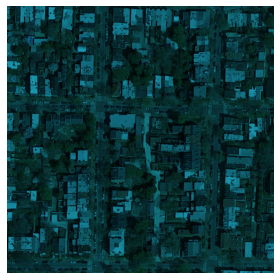

In [ ]:
# Transforming the Image according to certain RGB weights (usually generated at random)
rgb_weights = [0.1, 0.6, 0.7]                                                   # Weights by which channels are multiplied
images = tf.keras.utils.img_to_array(example_pic, dtype = 'float32')            # Convert picture to array (float32 dtype)                                                    

results = []
for x, i in enumerate(rgb_weights):                                             # Multiply each layer with respective weights
    results.append(images[:, :, x] * i)                         

exmaple_pic_rgb = tf.cast(results, tf.uint8)                                    # Image converted to its intial tensor format (tf.uint8 dtype)

# Plot the transformed image
plt.imshow(np.squeeze(np.transpose(exmaple_pic_rgb)))
plt.axis('off')
plt.tight_layout()
plt.show()

Now, let's combine the aforementioned aspects and features of our model. After loading the pre-trained ResNet50 base, we attach the individual components. The final model has 26.218.398 trainable parameters.

Model: "CNN_for_Geospatial_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 300, 300, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 300, 300, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 300, 300, 3)      0         
 tation)                                                         
                                                                 
 layers_rgb_change (layers_R  (None, 300, 300, 3)      0         
 GBChange)                                                       
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_1 (Flatten)         (Non

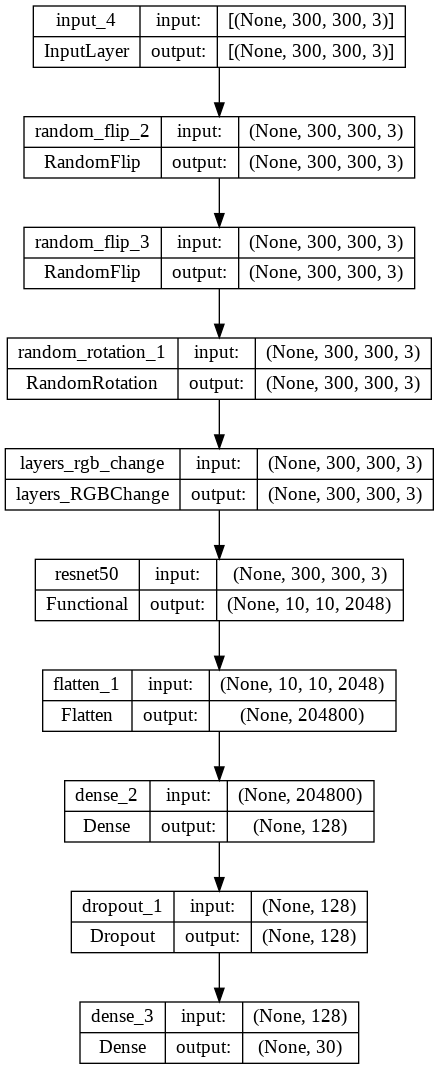

In [ ]:
# Loading ResNet50 pre-trained model
base_model = ResNet50(weights = 'imagenet',                                     # Use weights from ImageNet (large visual database)
                      include_top = False,                                      # Do not include the "head" (last layers)
                      input_shape = [300, 300, 3])                              # Input shape has to match resized images (300x300)
base_model.trainable = False                                                    # Freeze the weights, making the weight not trainable

# Create Model Architecture
model =  keras.models.Sequential([
    layers.InputLayer(input_shape = [300, 300, 3]),                             # Input layer adjusted to the size of re-sized images
    layers.RandomFlip(mode = 'horizontal'),                                     # The following layers are various data augmentation methods
    layers.RandomFlip(mode = 'vertical'),
    layers.RandomRotation(factor = 0.20),
    layers_RGBChange(),                                                         # Custom layer    

    base_model,                                                                 # Insert pre-trained layers / freezed weights

    layers.Flatten(),                                                           # Flatten layer to make input processable for fully-connected layers 
    layers.Dense(units = 128, activation = 'relu'),                             # Dense layer to start the fully-connected classifier head
    layers.Dropout(0.3),                                                        # Droput layer to control for overfitting
    layers.Dense(units = 30, activation = 'softmax')                            # Softmax activation for multiclass classificaiton of 30 classes
],  name = 'CNN_for_Geospatial_Classification')

model.summary()
plot_model(model, to_file = 'model_plot.png', 
           show_shapes = True, 
           show_layer_names = True)

### ***Model Configuration***

Next, two more steps are required before model fitting can commence:


1. **Compiling**: Once the model is created, we can configure the optimizer, used loss function, and additional metrics important for the training procedure. The optimizer primarily handles settings like the learning rate. Here, we chose the popular "adam" optimizer with a fixed learning rate of `η = 0.001` as an adaptive one lead to exponential runtimes, even when using a pre-trained base. Given our approach concerns the classification of multiple distinct categories, the loss would be appropriately captured by the categorical cross-entropy function, which compares sets of predicted probabilities. As we encoded classes as integers we have to use `sparse_categorical_crossentropy` when defining the loss. Lastly, we can define additional metrics of interest. We decided to include `accuracy` as it provides useful information when assessing the classification accuracy of the model regarding the numerous classes and, thus, gives another good intuition of how well our algorithm performs. 

2. **Early Stopping**: A popular method for preventing the model of reaching very high variance and low bias territories is called early stopping. Often, models tend to fit too close to the data, capturing noise in the process next to some systematic patterns. This process is called **overfitting**. Using early stopping, we can partially prevent this phenomenon from happening. Essentially, the technique stops the training procedure as soon as it detects that the validation loss is rising again. We can define this for the function: `tf.keras.callbacks.EarlyStopping`. Here, `min_delta` defines the smallest change in loss that still counts as an improvement and `patience` the number of epochs the algorithm waits for this smallest change to take affect. Another benefit of this method is that it recovers the weights from the point at which the validation loss was smallest using `restore_best_weights`. We decided to put patience on 50 as the model still converged on higher epochs and smaller patience values led to stopping too early on in the training.

In [ ]:
# Model Configuration
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),                # Adam optimizer by tensorflow, using a learning rate of 0.001
    loss = 'sparse_categorical_crossentropy',                                   # Loss function: used for integer instead of one-hot encoded multiclass approaches
    metrics = ['accuracy']                                                      # Accuracy as additional metric to assess model performance
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta = 0,                                                              # Minimum amount of change to count as an improvement
    patience = 50,                                                              # How many epochs to wait before stopping
    restore_best_weights = True,                                                # Restore weights from "best" model
)

### ***Model Training***

Next, we will fit the models. In order to evaluate the loss and accuracy metrics appropriately and, consequently, test the models' performance on new data, the validation data set will be included in the model fitting procedure. The validation loss may start increasing during training, due to the model learning noise and eventually overfitting the data. Thus, the model will be trained on 200 epochs, however, a callback is implemented, enabling early stopping in case the predefined conditions (e.g., min_delta, patience) arise. The history of the fitting procedure will be saved for visualization and analysis purposes.

In [ ]:
# Model Training
history = model.fit(
    train_set,                                                                  # Training data set
    validation_data = val_set,                                                  # Validation data set
    epochs = 200,                                                               # Number of epochs the model will be trained
    callbacks = [early_stopping],                                               # Callback in order to avoid overfitting / retain "best weights"
    verbose = 1
)

## **Results and Analyses**

### ***Visualization of Fitting Procedure***

After successful training, it makes sense to visually investigate the metrics defined in our model configuration. Accordingly, we visualized the loss and accuracy, respectively, of the training and validation data for both types of models. By comparing the key metrics of the baseline vs. experimental (RGB) model we can intuitively compare their performance and decide which model to keep for further analysis. Additionally, the figures give a good indication of potential cases of overfitting as the training accuracy may greatly surpass the validation accuracy. Similarly, the loss gives an intuition for the training procedure over the trained epochs and potential deviations when looking at the validation data. 

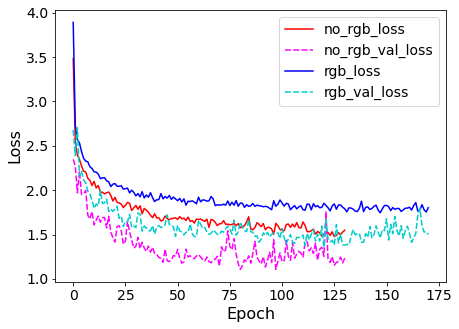

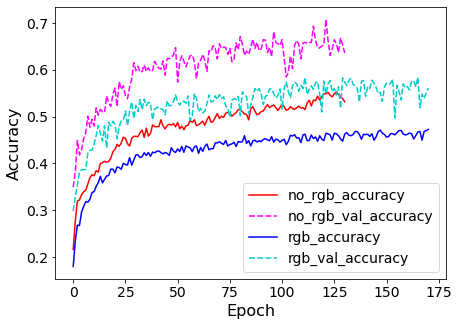

In [ ]:
# Import training history objects from the Drive folder
history_no_rgb = pd.read_pickle(r'/content/drive/MyDrive/DLiP_Group6/HistoryNoRGB')
history_rgb = pd.read_pickle(r'/content/drive/MyDrive/DLiP_Group6/HistoryRGB')

# Prepare histories for plotting
history_no_rgb_frame = pd.DataFrame(history_no_rgb)                             # Convert histories into DataFrames
history_no_rgb_frame.columns = ['no_rgb_loss',                                  # Rename DataFrame columns to be informative
                                'no_rgb_accuracy',
                                'no_rgb_val_loss',
                                'no_rgb_val_accuracy']

history_rgb_frame = pd.DataFrame(history_rgb)
history_rgb_frame.columns = ['rgb_loss',
                             'rgb_accuracy',
                             'rgb_val_loss',
                             'rgb_val_accuracy']

# Plot both models' loss over training epochs
plt.figure(figsize = (7, 5))
sns.lineplot(data = history_no_rgb_frame.loc[:, ['no_rgb_loss',
                                                 'no_rgb_val_loss']],
             palette = ['red', 'magenta'])                                      
sns.lineplot(data = history_rgb_frame.loc[:, ['rgb_loss',
                                              'rgb_val_loss']],
             palette = ['blue', '#00CCCC'])                                     
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14) 

# Plot both models' accuracy over training epochs
plt.figure(figsize = (7, 5))
sns.lineplot(data = history_no_rgb_frame.loc[:, ['no_rgb_accuracy',
                                                 'no_rgb_val_accuracy']],
             palette = ['red', 'magenta'])
sns.lineplot(data = history_rgb_frame.loc[:, ['rgb_accuracy',
                                              'rgb_val_accuracy']],
             palette = ['blue', '#00CCCC'])
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

### ***Model Evaluation on Test Set*** ##
The above comparison, however, is only covering the realm of train and validation data. Let's see how the models perform on unseen data, namely our witheld test dataset, to investigate their general predictive performance and generalizability to new situations.


In [ ]:
print('Loss & Accuracy of Baseline Model:')
test_score1, test_acc1 = model_no_rgb.evaluate(test_set_)
print('Loss & Accuracy of RGB Model:')
test_score2, test_acc2 = model_rgb.evaluate(test_set_)

Loss & Accuracy of Baseline Model:
62/62 [==============================] - 3s 47ms/step - loss: 1.0391 - accuracy: 0.6835
Loss & Accuracy of RGB Model:
62/62 [==============================] - 3s 47ms/step - loss: 1.5914 - accuracy: 0.5811


Results from the visual investigation of accuracy and loss as well as predictions on the test set show that the no-RGB model outperforms the RGB model. Precisely, on unseen data it achieves better prediction accuracy (68.4% vs. 58.1%) and converges better (i.e., lower loss; 1.04 vs. 1.60). Therefore, further sections will investigate the predictions and generalizability of *only* the no-RGB (baseline) model.

**Note**: Reason for the superior validation accuracy and loss compared to its training counterpart, as can be seen in the above plots, is caused by the dropout layer which is only applied to the training cases. Thus, the training metrics tend to perform worse as the predictions are more restricted.

### ***Receiver Operating Characteristic (ROC)***

Plotting Receiver Operating Characteristic (ROC) curves can help evaluate the predictions from a given classifier. The curve shows the performance of a classifier by plotting the True Positive Rate (TPR) and False Positive Rate (FPR) given all possible thresholds.

Because the TPR and FPR are needed for plotting ROC curves, they are most commonly used for evaluating binary classifiers, since the calculation of the two is straightforward. However, in the case of a multiclass classifier as ours, we can binarize the model output to compare a given class against the rest altogether, e.g., does a given image belong to the class 'Airport' or to the _rest_ of the classes? This "scheme" for plotting ROCs of multiclass classifiers is known as One-vs-Rest (OvR) ROC.

At the beginning of the notebook we defined a few functions to help accomplish the above steps. We will compute the chosen model's predictions on the test dataset, which we'll use for plotting the ROCs.

In [ ]:
# Get class predictions for test set
test_images = test_set_.unbatch()

images = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
labels = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

for x, y in test_set_.unbatch():
    images = images.write(images.size(), x)
    labels = labels.write(labels.size(), y)

images = tf.stack(images.stack(), axis=0)
labels = tf.stack(labels.stack(), axis=0)

pred_probs = np.zeros((1,30))
for i in range(len(images)):
    pred = model_no_rgb.predict(np.expand_dims(images[i], axis=0))
    pred_probs = np.vstack((pred_probs, pred))
pred_probs = pred_probs[1:]

labels_names = [class_names[label] for label in labels]

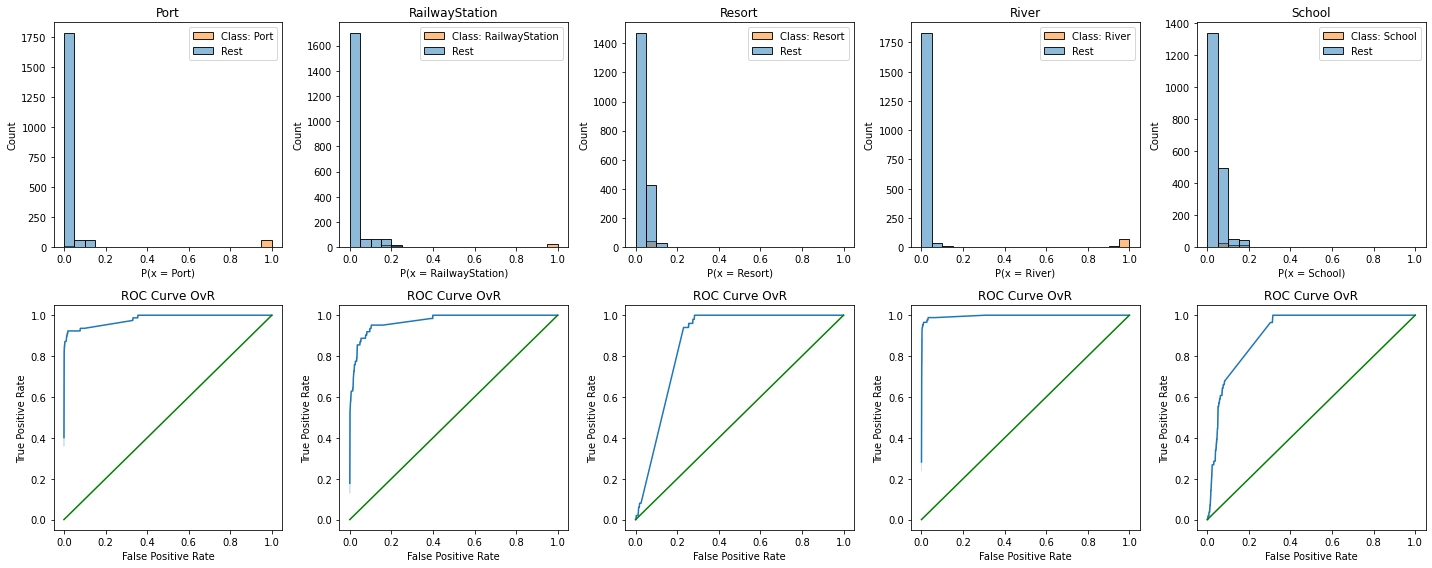

In [ ]:
# Plot the Probability Distributions and the ROC Curves, One vs Rest
# Inspired by: https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb
plt.figure(figsize = (20, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}
w = 0                                                                           # Plot window counter

for i in range(len(class_names))[20:25]:                                        # Plotting 5 exemplary classes for space
    # Gets the class
    c = class_names[i]
    
    # Prepares an auxiliary dataframe to help with the plots
    df_aux = pd.DataFrame(
        np.zeros((pred_probs.shape[0], 2)),
        columns = ['class', 'prob']
        )

    df_aux['class'] = [1 if y == c else 0 for y in labels_names]
    df_aux['prob'] = pred_probs[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 5, w+1)
    sns.histplot(
        x = "prob",
        data = df_aux, 
        hue = 'class',
        color = 'b',
        ax = ax,
        bins = bins
        )
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 5, w+6)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")

    w += 1
    
plt.tight_layout()

In [ ]:
# Calculate ROC AUC for each class
roc_auc_ovr = {}
for i in range(len(class_names)):
    # Gets the class
    c = class_names[i]
    
    # Prepares an auxiliary dataframe to help with the plots
    df_aux = pd.DataFrame(
        np.zeros((pred_probs.shape[0], 2)),
        columns = ['class', 'prob']
        )

    df_aux['class'] = [1 if y == c else 0 for y in labels_names]
    df_aux['prob'] = pred_probs[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

# Print results for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"\nAverage ROC AUC OvR: {avg_roc_auc/i:.4f}")

Airport ROC AUC OvR: 0.8813
BareLand ROC AUC OvR: 0.9935
BaseballField ROC AUC OvR: 0.9538
Beach ROC AUC OvR: 0.9999
Bridge ROC AUC OvR: 0.9997
Center ROC AUC OvR: 0.9116
Church ROC AUC OvR: 0.8773
Commercial ROC AUC OvR: 0.9381
DenseResidential ROC AUC OvR: 0.9587
Desert ROC AUC OvR: 0.9999
Farmland ROC AUC OvR: 0.9911
Forest ROC AUC OvR: 0.9951
Industrial ROC AUC OvR: 0.9579
Meadow ROC AUC OvR: 1.0000
MediumResidential ROC AUC OvR: 0.9532
Mountain ROC AUC OvR: 0.9955
Park ROC AUC OvR: 0.9036
Parking ROC AUC OvR: 0.9961
Playground ROC AUC OvR: 0.9856
Pond ROC AUC OvR: 0.9849
Port ROC AUC OvR: 0.9811
RailwayStation ROC AUC OvR: 0.9715
Resort ROC AUC OvR: 0.8728
River ROC AUC OvR: 0.9966
School ROC AUC OvR: 0.9079
SparseResidential ROC AUC OvR: 0.9999
Square ROC AUC OvR: 0.8933
Stadium ROC AUC OvR: 0.9884
StorageTanks ROC AUC OvR: 0.8992
Viaduct ROC AUC OvR: 1.0000

Average ROC AUC OvR: 0.9596


The ROC curves and ROC AUCs show that the model learns how to separate a given class from the rest well, with an average ROC AUC OvR of 0.96. ROC curves hugging the top left corner indicate reasonable separability of classes, which our trained model is doing for the example cases illustrated above.

### ***Confusion Matrix***

To better understand what kinds of mistakes the model does when classifying, we plot the true labels against the predicted labels (of the test set) in a confusion matrix.

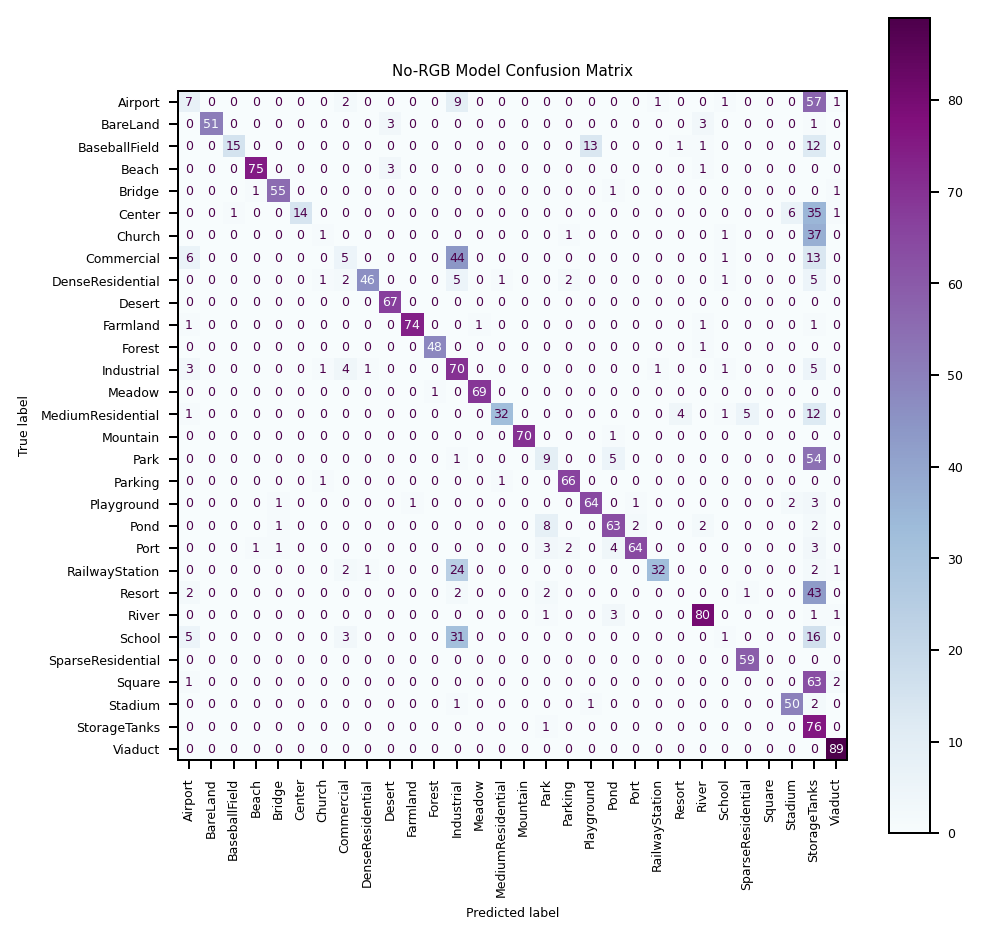

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

pred_classes = pred_probs.argmax(axis = 1)
pred_classes_names = [class_names[pred] for pred in pred_classes]

fig, ax = plt.subplots(figsize=(6, 6), dpi = 180)
disp = ConfusionMatrixDisplay.from_predictions(
    labels_names,
    pred_classes_names,
    labels=class_names,
    ax = ax,
    cmap=plt.cm.BuPu,
    xticks_rotation = 90
)
ax.set_title('No-RGB Model Confusion Matrix')
plt.rcParams['font.size'] = '8'

We see that the model shows high sensitivity for most classes, with the Industrial and StorageTanks classes "absorbing" most of the mistakes.

## **Predicting Satellite Images using GPS Data** ##

The last step of this endeavor concerns the external validity of the trained classification algorithm: 

> Given any satellite image, can our (best) model reasonably identify the new images presented to it?

In order to assess this in an engaging way, the authors of the present paper wrote a function accessing Google Maps API and retrieving satellite images from the companies geospatial-infrastructure (located within the helper functions section at the beginning). Note, the API in question concerns Google's publicly available Maps Static API, which provides static images from the companies repository. Hence, the displayed images are static and do not deliver a dynamical representation of the chosen area (dynamical resources are offered by NASA through devices such as their Sentinel satellite). Nonetheless, Google Maps frequently updates their representations, providing currency.

By defining the latitude and longitude coordinates of any given location on the earth's surface, users receive a visualization of these coordinates (= the satellite image) accompanied by the prediction made by the trained model. By navigating to [Google Maps](https://www.google.com/maps) and right-clicking any point on the map, users can conveniently copy-paste the coordinates into the below function.




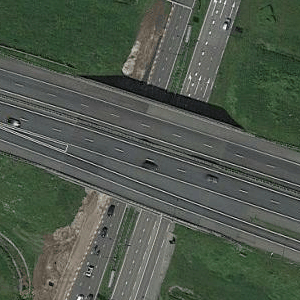

'Viaduct'

In [ ]:
# Example Prediction (feel free to insert any latitude and longitude coordinates)
predict_satellite_image(52.32378448863493, 6.6471852667752644)

Let's investigate random coordinates and satellite images to see what our model thinks about them! Google Maps unfortunately does not have images for *all* locations, hence, sometimes images are not available. Simply refresh!

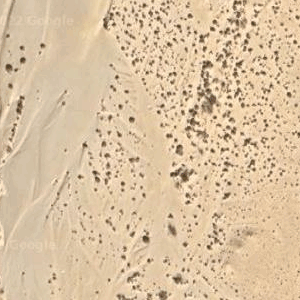

'Desert'

In [ ]:
# Let's look at the satellite images from the following 10 countries
countries = ['US', 'GB', 'AU', 'IN', 'DE', 'ES', 'NZ', 'TW', 'JP', 'GH'] 

# Creating random latitude and longitude coordinates
lat_log = []
for i in range(len(countries)):
    lat_log.append(Faker().local_latlng(country_code = countries[i])) 

# Finally, let's predict these random locations
predict_satellite_image(float(lat_log[random.randrange(10)][0]), 
                        float(lat_log[random.randrange(10)][1]))

## **Discussion and Concluding Remarks** ##

### ***Summary***
We...

* ...read-in and utilized data from the [Aerial Image Dataset](https://paperswithcode.com/dataset/aid) (Xia et al., 2017)
* ...built a Convolutional Neural Network using the pre-trained ResNet50 
* ...built a custom data preprocessing layer to manipulate the RGB values of each picture individually
* ...trained and tuned the model until a satisfying accuracy was achieved
* ...extensively visualized the models key metrics (e.g., loss, accuracy, ROC) in order to compare our approaches
* ...provided a custom function to assess the model's performance on real-life data

  

### ***Conclusion***
The no-RGB model performs better on the AID dataset than the RGB model, and achieves good separability of a given class vs. the remaining 29 (see AUC ROC values above). The model performs best on natural classes (e.g., rivers, mountains, forests), but misclassifies several human-made structures (e.g., airports, churches, railways) into two "catch-all's" – industrial districts and storage tanks. “Industrial” seems to capture more jagged/scattered buildings like railways and commercial districts, while “StorageTanks” captures round-shaped, well-defined objects like churches. Moreover, the model generalizes well – as shown by our custom prediction function - and identifies general structures well, at most missclassifying similar landscapes (Playground vs. BaseballField).

### ***Limitations***
When investigating the data, we found there were more storage tank images than resort, church, or airport images, meaning that predicting “StorageTanks” in these cases might’ve been a strategy to achieve higher accuracy on hard-to-discriminate classes. Balancing the classes is recommended for future research.

Also, we expected the RGB augmentation to aid in generalizability (since satellite images often have odd exposure / color balancing); however, this did not happen. Likely, our RGB manipulation was too “broad” – randomly shifting the RGB channels by any factor might be overkill. Specifying a reasonable range of RGB shift values could lead to the RGB model outperforming the no-RGB one.

We expect these two suggestions to improve the Bayes upper bound for error, closing in on previous findings (Kadhim & Abed, 2019). Currently, the model is sitting at human performance levels.

## **References** ##
* Albert, A., Kaur, J., & Gonzalez, M. C. (2017, August). Using convolutional networks and satellite imagery to identify patterns in urban environments at a large scale. In *Proceedings of the 23rd ACM SIGKDD international conference on knowledge discovery and data mining* (pp. 1357-1366). https://doi.org/10.1145/3097983.3098070

* He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 770-778). https://doi.org/10.1109/CVPR.2016.90

* Kadhim, M. A., & Abed, M. H. (2019, April). Convolutional neural network for satellite image classification. In *Asian Conference on Intelligent Information and Database Systems* (pp. 165-178). Springer, Cham. https://doi.org/10.1007/978-3-030-14132-5_13

* Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2017). ImageNet classification with deep convolutional neural networks. *Communications of the ACM, 60*(6), 84–90. https://doi.org/10.1145/3065386

* Xia, G. S., Hu, J., Hu, F., Shi, B., Bai, X., Zhong, Y., ... & Lu, X. (2017). AID: A benchmark data set for performance evaluation of aerial scene classification. *IEEE Transactions on Geoscience and Remote Sensing, 55*(7), 3965-3981. https://doi.org/10.1109/TGRS.2017.2685945